Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 255, 384, 3))
  warnings.warn(msg)



▶ Starting Optimization...

Iteration 1/100 | Total Loss: 1034892992.000000
Iteration 20/100 | Total Loss: 416610240.000000
Iteration 40/100 | Total Loss: 330766720.000000
Iteration 60/100 | Total Loss: 293241408.000000
Iteration 80/100 | Total Loss: 272986112.000000
Iteration 100/100 | Total Loss: 260111616.000000

Saved to: /content/drive/MyDrive/A. STMIK IKMI (TI)/Semester 6/DLD/Image/NST_BEST.png


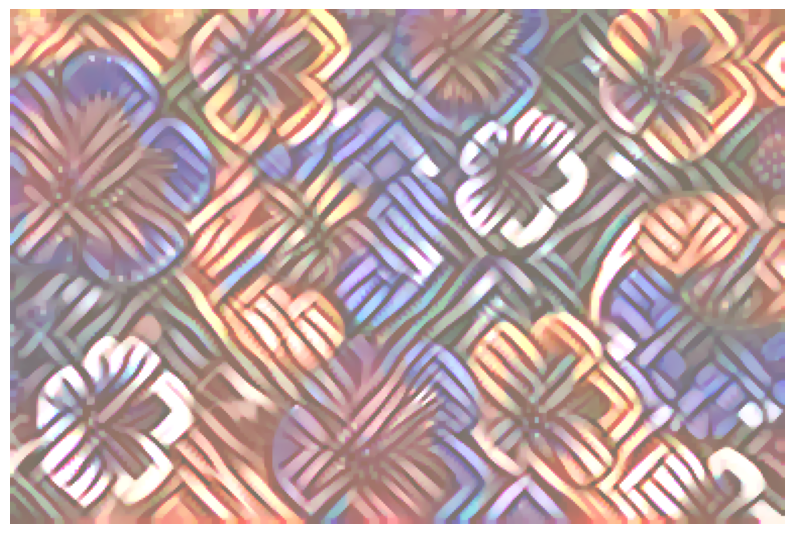

In [ ]:
# -------------------------
# 1. Mount Google Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------
# 2. Import libraries
# -------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

# -------------------------
# 3. Image loader (optimized)
# -------------------------
def load_img(path_to_img, max_dim=384):
    """Load image, resize proportionally, return float32 tensor."""
    img = Image.open(path_to_img).convert('RGB')
    long_dim = max(img.size)
    scale = max_dim / long_dim
    new_w = int(img.size[0] * scale)
    new_h = int(img.size[1] * scale)
    img = img.resize((new_w, new_h), Image.LANCZOS)

    img = np.array(img).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

def vgg_preprocess(img):
    """VGG19 preprocess."""
    return tf.keras.applications.vgg19.preprocess_input(img)

def deprocess_img(img):
    """Reverse VGG preprocessing → uint8 normal image."""
    x = img.copy()
    if x.ndim == 4:
        x = np.squeeze(x, axis=0)

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]  # BGR → RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# -------------------------
# 4. Optimized Style & Content Layer Setup
# -------------------------
STYLE_LAYERS = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

CONTENT_LAYERS = ['block5_conv2']

# -------------------------
# 5. VGG19 Model loader
# -------------------------
def get_model():
    """Load VGG19 and output selected layer features."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in (STYLE_LAYERS + CONTENT_LAYERS)]
    return tf.keras.Model([vgg.input], outputs)

# -------------------------
# 6. Gram Matrix (style representation)
# -------------------------
def gram_matrix(tensor):
    """Compute Gram Matrix."""
    x = tf.transpose(tensor, (0, 3, 1, 2))
    b, c, h, w = x.shape
    features = tf.reshape(x, (b, c, h*w))
    gram = tf.matmul(features, features, transpose_b=True)
    return gram / tf.cast(h * w, tf.float32)

# -------------------------
# 7. Extract features
# -------------------------
def get_feature_representations(model, content_path, style_path):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    content_input = vgg_preprocess(content_image)
    style_input = vgg_preprocess(style_image)

    outputs_style = model(style_input)
    outputs_content = model(content_input)

    num_style = len(STYLE_LAYERS)
    style_features = [outputs_style[i] for i in range(num_style)]
    content_features = [outputs_content[num_style + i] for i in range(len(CONTENT_LAYERS))]

    return content_image, style_image, style_features, content_features

# -------------------------
# 8. Full Loss Function
# -------------------------
def compute_loss(model, init_image, gram_style_feats, content_feats,
                 style_weight, content_weight, tv_weight):

    img_pre = vgg_preprocess(init_image)
    outputs = model(img_pre)

    num_style = len(STYLE_LAYERS)
    style_outputs = outputs[:num_style]
    content_outputs = outputs[num_style:]

    # Style Loss
    style_loss = 0
    for gram_target, out in zip(gram_style_feats, style_outputs):
        gram_out = gram_matrix(out)
        style_loss += tf.reduce_mean(tf.square(gram_out - gram_target))
    style_loss *= style_weight / num_style

    # Content Loss
    content_loss = 0
    for target, out in zip(content_feats, content_outputs):
        content_loss += tf.reduce_mean(tf.square(out - target))
    content_loss *= content_weight

    # Total Variation Loss (smoothness)
    tv_loss = tv_weight * tf.reduce_sum(tf.image.total_variation(init_image))

    total = style_loss + content_loss + tv_loss
    return total, style_loss, content_loss, tv_loss

# -------------------------
# 9. Gradient Function
# -------------------------
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss, s_loss, c_loss, tv_loss = compute_loss(**cfg)
    grads = tape.gradient(loss, cfg['init_image'])
    return grads, loss, s_loss, c_loss, tv_loss

# -------------------------
# 10. Main NST Optimization Function
# -------------------------
def run_style_transfer(
    content_path,
    style_path,
    num_iterations=100,
    style_weight=5e-2,
    content_weight=1e4,
    tv_weight=20.0,
    learning_rate=3.0
):
    model = get_model()
    content_img, style_img, style_feats, content_feats = get_feature_representations(
        model, content_path, style_path
    )

    # Gram matrices
    gram_style_feats = [gram_matrix(f) for f in style_feats]

    # Init image = content image
    init_img = tf.Variable(content_img, dtype=tf.float32)

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    best_loss = float("inf")
    best_img = None

    cfg = {
        "model": model,
        "init_image": init_img,
        "gram_style_feats": gram_style_feats,
        "content_feats": content_feats,
        "style_weight": style_weight,
        "content_weight": content_weight,
        "tv_weight": tv_weight
    }

    print("\n▶ Starting Optimization...\n")

    for i in range(num_iterations):
        grads, loss, s_loss, c_loss, tv_loss = compute_grads(cfg)
        optimizer.apply_gradients([(grads, init_img)])
        init_img.assign(tf.clip_by_value(init_img, 0.0, 255.0))

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_img.numpy())

        if (i + 1) % 20 == 0 or i == 0:
            print(f"Iteration {i+1}/{num_iterations} | Total Loss: {loss:.6f}")

    return best_img

# ===========================================================
# 11. RUN NST — SET PATHS
# ===========================================================
STYLE_PATH  = "/content/drive/MyDrive/A. STMIK IKMI (TI)/Semester 6/DLD/Image/gambar style.jpeg"
CONTENT_PATH = "/content/drive/MyDrive/A. STMIK IKMI (TI)/Semester 6/DLD/Image/gambar utama.jpeg"

# RUN WITH OPTIMAL SETTINGS
result = run_style_transfer(
    CONTENT_PATH,
    STYLE_PATH,
    num_iterations=100,     # Best quality under 1 minute (GPU)
    style_weight=5e-2,
    content_weight=1e4,
    tv_weight=20.0,
    learning_rate=3.0
)

# ===========================================================
# 12. Show Results
# ===========================================================
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.axis("off")

# Save result
out_path = "/content/drive/MyDrive/A. STMIK IKMI (TI)/Semester 6/DLD/Image/NST_BEST.png"
Image.fromarray(result).save(out_path)
print("\nSaved to:", out_path)
